## Imports

In [31]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PIL for image operations
from PIL import Image

# For plotting and visualizations
import matplotlib.pyplot as plt

# For array operations
import numpy as np

# TensorBoardX: TensorBoard for PyTorch
from tensorboardX import SummaryWriter

## Setup Neural Networks

In [32]:
# This ConvNet could be used instead of the "ComplexCNN". It has less layers, and likely can detect less features, but is also less likely to overfit and faster
class CNN(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Dropout layer after convolutional layers (optional)
        self.dropout_conv = nn.Dropout(p=dropout_prob/2)  # Typically, dropout in convolutional layers is kept lower

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 64)  # After 2 max-pooling operations, the size becomes (28/2/2 = 7)

        # Dropout layer for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Conv layer 1 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)  # Reducing spatial dimensions by half
        x = self.dropout_conv(x)  # Dropout after pooling (optional)

        # Conv layer 2 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)  # Reducing spatial dimensions by half
        x = self.dropout_conv(x)  # Dropout after pooling (optional)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout after activation
        x = self.fc2(x)

        return x

In [33]:
# This ConvNet is more complex with more layers than the "standard" ConvNet defined above
class ComplexCNN(nn.Module):
    def __init__(self, dropout_prob=0.4):
        super(ComplexCNN, self).__init__()

        # Convolutional Blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=dropout_prob/2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=dropout_prob/2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=dropout_prob/2)
        )

        # Will be initialized in the forward pass
        self.fc1 = None

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Dynamically creating the fc1 layer if not done yet
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.view(x.size(0), -1).size(1), 256).to(x.device)

        # Flatten and apply FC layers
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc_layers(x)

        return x

## Set Up Device Agnostic Code

In [34]:
# Set the device to GPU if available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Hyperparamters

In [35]:
num_classes = 2
learning_rate = 0.0006
batch_size = 32
num_epochs = 9

## Data
- Load Data
- Split Data
- Apply transformations

In [36]:
class AlbumentationsTransform:
    """Transforms image using the Albumentations library and converts to a PyTorch tensor."""
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, image):
        image_np = np.array(image)
        augmented = self.transform(image=image_np)
        image_tensor = torch.tensor(augmented['image'], dtype=torch.float32).permute(2, 0, 1) / 255.0
        return image_tensor

In [37]:
# Using data augmentation with the albumentations library
augmentation = A.Compose([
    A.Resize(256, 256),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.1),
    A.CLAHE(p=0.2),
    A.HorizontalFlip(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=5, p=0.25),
    A.GaussNoise(p=0.04),
    A.GaussianBlur(p=0.04),
    A.OpticalDistortion(p=0.02),
    A.GridDistortion(p=0.02),
    # A.ToTensorV2()  # Convert the image to PyTorch tensor. It should be the last transform.
])

test_augmentation = A.Compose([
    A.Resize(256, 256)
])

wrapped_augmentation = AlbumentationsTransform(augmentation)
wrapped_test_augmentation = AlbumentationsTransform(test_augmentation)

In [21]:
wrapped_augmentation = AlbumentationsTransform(augmentation)
wrapped_test_augmentation = AlbumentationsTransform(test_augmentation)

In [22]:
class CustomDataset(Dataset):
    # Custom dataset that applies Albumentations and loads images from paths.
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.augmentations = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        image = Image.open(path).convert("RGB")
        if self.augmentations:
            image = self.augmentations(image)
        return image, target


In [23]:
root_directory = '/Users/jacob/OneDrive/Desktop/Aletheia/Dataset_1/'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(42)

# Split dataset into train, validation, and test
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(train_subset, transform=wrapped_augmentation)
validation_dataset = CustomDataset(validation_subset, transform=wrapped_test_augmentation)
test_dataset = CustomDataset(test_subset, transform=wrapped_test_augmentation)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Explore and Visualize Data

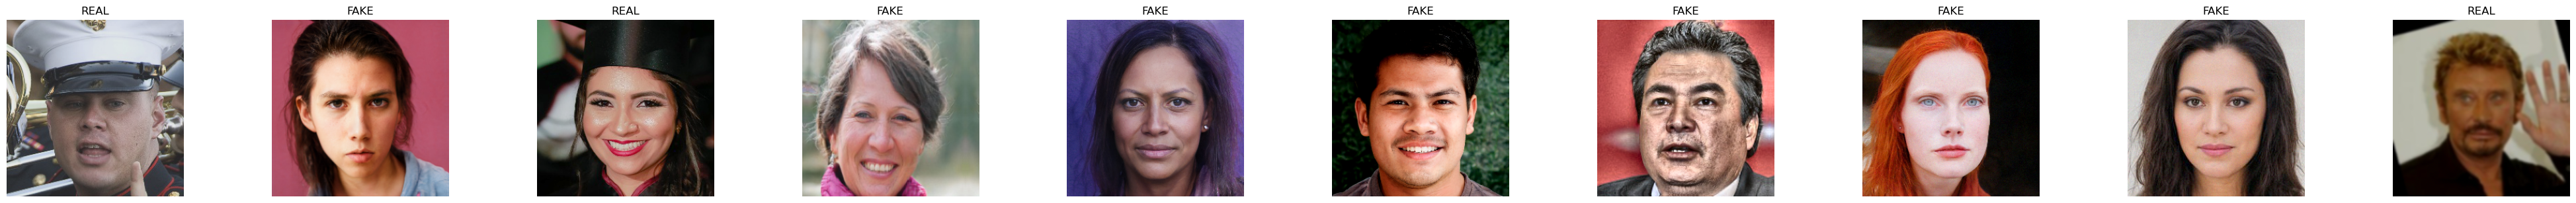

In [24]:
def imshow_with_labels(dataloader, class_names, num_images=10):
    """Display a batch of images with labels.
    Parameters:
    - dataloader (DataLoader): PyTorch DataLoader containing images and labels.
    - class_names (list): List of class names for labeling.
    - num_images (int, optional): Number of images to display. Default is 10.
    """
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(1, num_images, figsize=(50, 50), 
                             subplot_kw={'xticks':[], 'yticks':[], 'frame_on':False})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for ax, img, lbl in zip(axes, images, labels):
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[lbl])
    
    plt.show()

# Using the function to display a batch
imshow_with_labels(train_loader, class_names=full_dataset.classes)

## Training

### Prepare Training

In [25]:
# Set a fixed random seed for reproducibility
torch.manual_seed(42)

# Initialize the model and transfer it to the appropriate device (GPU or CPU)
model = ComplexCNN().to(device)

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

In [27]:
writer = SummaryWriter(f'runs/SingleModel/3')
step = 0

## Define Function for Determining Accuracy of Model

In [28]:
def check_accuracy(loader, model):
    """
    Check the accuracy of the model on a given DataLoader.

    Parameters:
    - loader (DataLoader): DataLoader instance containing the dataset on which accuracy needs to be checked.
    - model (nn.Module): PyTorch model instance which needs to be evaluated.
    """

    print(type(loader))
    num_correct = 0
    num_samples = 0

    # Set the model to evaluation mode.
    model.eval()

    # Ensure no gradients are computed to save memory
    with torch.no_grad():
        for x, y in loader:

            # Move the data and labels to the appropriate device
            x = x.to(device=device)
            y = y.to(device=device)

            # Make predictions using the model
            scores = model(x)

            # Convert raw scores (logits) to binary predictions
            predictions = (torch.sigmoid(scores) > 0.5).squeeze().long()

            # Accumulate the number of correct predictions and total samples
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    # Set the model back to training mode
    model.train()

# check_accuracy(train_loader, model)
# check_accuracy(test_loader, model)

## Train Model

In [16]:
num_correct = 0
num_samples = 0

torch.manual_seed(42)

model = model.to(device=device)
log_interval = 100

for epoch in range(num_epochs):
    # Resetting accuracy counters at the beginning of each epoch
    num_correct = 0
    num_samples = 0
    
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = criterion(scores.view(-1), targets.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent (or whatever optimizer you're using)
        optimizer.step()

        predictions = (torch.sigmoid(scores) > 0.5).float()
        num_correct += (predictions == targets).sum().item()
        num_samples += predictions.size(0)

        accuracy = 100 * num_correct / num_samples

        # Log the metrics to TensorBoard
        if batch_idx % log_interval == 0:
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_idx)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_idx)
            # print("Epoch: ", epoch)
            # print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')

    print("Epoch: ", epoch)
    print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')
    scheduler.step()

    # Check accuracy on the test loader after each epoch
    print("Checking accuracy on Test Data")
    check_accuracy(validation_loader, model)  # Checking the accuracy on the test set
    test_accuracy = 100 * float(num_correct) / float(num_samples)
    writer.add_scalar('Test Accuracy', test_accuracy, epoch)  # Add test accuracy to TensorBoard

    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/model2_epoch_{epoch}_num_correct{num_correct}.pth')

c:\Users\jacob\miniconda3\envs\env_two\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:  0
Got 185263 / 232652 with accuracy 79.63
Checking accuracy on Test Data
<class 'torch.utils.data.dataloader.DataLoader'>
Got 11262 / 13685 with accuracy 82.29
Epoch:  1
Got 191638 / 232652 with accuracy 82.37
Checking accuracy on Test Data
<class 'torch.utils.data.dataloader.DataLoader'>
Got 11504 / 13685 with accuracy 84.06
Epoch:  2
Got 194582 / 232652 with accuracy 83.64
Checking accuracy on Test Data
<class 'torch.utils.data.dataloader.DataLoader'>
Got 11735 / 13685 with accuracy 85.75
Epoch:  3
Got 197009 / 232652 with accuracy 84.68
Checking accuracy on Test Data
<class 'torch.utils.data.dataloader.DataLoader'>
Got 12191 / 13685 with accuracy 89.08
Epoch:  4
Got 199142 / 232652 with accuracy 85.60
Checking accuracy on Test Data
<class 'torch.utils.data.dataloader.DataLoader'>
Got 12262 / 13685 with accuracy 89.60
Epoch:  5
Got 200500 / 232652 with accuracy 86.18
Checking accuracy on Test Data
<class 'torch.utils.data.dataloader.DataLoader'>
Got 12169 / 13685 with accurac

## Test state_dict of Trained Model

In [30]:
model = ComplexCNN().to(device)
model_path = '/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/model2_epoch_2_num_correct194582.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for ComplexCNN:
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias". 

In [24]:
check_accuracy(test_loader, model)

<class 'torch.utils.data.dataloader.DataLoader'>
Got 13172 / 27372 with accuracy 48.12
